In [1]:
#import
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings("ignore")
from statsmodels.regression.linear_model import OLS
import random
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set(style="whitegrid")
import copy
myfont = FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf', size=10)
sns.set(
    font=myfont.get_name(),
    style="whitegrid",
    palette="muted",
    color_codes=True)

In [2]:
#data
amt = pd.read_csv('amt.csv', index_col=0)
close = pd.read_csv('close.csv', index_col=0)
open_p = pd.read_csv('open.csv', index_col=0)
volume = pd.read_csv('volume.csv', index_col=0)
turn = pd.read_csv('turn.csv', index_col=0)
free_float_shares = pd.read_csv('free_float_shares.csv', index_col=0)
low = pd.read_csv('low.csv', index_col=0)
high = pd.read_csv('high.csv', index_col=0)
adjfactor = pd.read_csv('adjfactor.csv', index_col=0)
mkt_cap_ard = pd.read_csv('mkt_cap_ard.csv', index_col=0)
total_shares = pd.read_csv('total_shares.csv', index_col=0)
mf_amt = pd.read_csv('mf_amt.csv', index_col=0)
amt.columns = [int(i) for i in amt.columns]
close.columns = [int(i) for i in close.columns]
open_p.columns = [int(i) for i in open_p.columns]
volume.columns = [int(i) for i in volume.columns]
turn.columns = [int(i) for i in turn.columns]
free_float_shares.columns = [int(i) for i in free_float_shares.columns]
low.columns = [int(i) for i in low.columns]
high.columns = [int(i) for i in high.columns]
adjfactor.columns = [int(i) for i in adjfactor.columns]
mkt_cap_ard.columns = [int(i) for i in mkt_cap_ard.columns]
total_shares.columns = [int(i) for i in total_shares.columns]
mf_amt.columns = [int(i) for i in mf_amt.columns]
mkt_cap_free_float = free_float_shares * close
adjclose = adjfactor * close
adjlow = adjfactor * low
adjhigh = adjfactor * high
adjopen = adjfactor * open_p
ohlc_sigma_c = (1/2 * (np.log(adjhigh/adjlow)) - (2 * np.log(2) - 1) * (np.log(adjclose/adjopen))) ** (1/2)
def process(df):
    return df.loc[df.fillna(method='ffill').dropna().index].fillna(0)
volume = volume.apply(process)
volume_rolling = volume.rolling(window=10).mean()
ohlc_sigma_c_rolling = ohlc_sigma_c.rolling(window=10).mean()
free_float_shares_rolling = free_float_shares.rolling(window=10).mean()
vwap = amt/volume
adjvwap = amt/volume * adjfactor
mf_volume = mf_amt/vwap

In [3]:
def EL(calc_day,
       delta=5,
       volume_data=volume,
       free_float_shares_data=free_float_shares,
       low_data=adjlow,
       high_data=adjhigh):
    calc_day_index = volume_data.index.tolist().index(calc_day)
    Pmin_mid = low_data.iloc[:calc_day_index + 1]
    Pmax_mid = high_data.iloc[:calc_day_index + 1]
    Q_mid = volume_data.iloc[:calc_day_index + 1]
    M_mid = free_float_shares_data.iloc[:calc_day_index + 1]
    available = Q_mid.xs(calc_day).replace(0, np.nan).dropna().index.tolist()
    Pmin_mid = Pmin_mid.loc[:, available]
    Pmax_mid = Pmax_mid.loc[:, available]
    Q_mid = Q_mid.loc[:, available]
    M_mid = M_mid.loc[:, available]
    for stock in available:
        if (Q_mid[stock].iloc[-delta:] > 0).sum() != delta:
            sub_Pmin_mid = Pmin_mid[stock][Q_mid[stock] > 0]
            sub_Pmin_mid.index = Pmin_mid.index.tolist()[-len(sub_Pmin_mid):]
            Pmin_mid[stock] = sub_Pmin_mid
            sub_Pmax_mid = Pmax_mid[stock][Q_mid[stock] > 0]
            sub_Pmax_mid.index = Pmax_mid.index.tolist()[-len(sub_Pmax_mid):]
            Pmax_mid[stock] = sub_Pmax_mid
            sub_M_mid = M_mid[stock][Q_mid[stock] > 0]
            sub_M_mid.index = M_mid.index.tolist()[-len(sub_M_mid):]
            M_mid[stock] = sub_M_mid
            #Q must be the last one to be calculated
            sub_Q_mid = Q_mid[stock][Q_mid[stock] > 0]
            sub_Q_mid.index = Q_mid.index.tolist()[-len(sub_Q_mid):]
            Q_mid[stock] = sub_Q_mid
    Pmin = (Pmin_mid.iloc[-delta:]).T.dropna().T.min()
    Pmax = (Pmax_mid.iloc[-delta:]).T.dropna().T.max()
    Q = (Q_mid.iloc[-delta:]).T.dropna().T.mean()
    M = (M_mid.iloc[-delta:]).T.dropna().T.mean()
    VR = ((Pmax - Pmin).replace(0, 0.01)) / Pmin
    return (Q / M) / VR

In [4]:
def EL_score(needed_volume, calc_day, delta = 5, volume_data = volume, free_float_shares_data = free_float_shares, \
    low_data = adjlow, high_data = adjhigh):
    volume_data = volume_data.loc[:, needed_volume.index]
    free_float_shares_data = free_float_shares_data.loc[:, needed_volume.index]
    low_data = low_data.loc[:, needed_volume.index]
    high_data = high_data.loc[:, needed_volume.index]

    calc_day_index = volume_data.index.tolist().index(calc_day)
    Pmin_mid = low_data.iloc[:calc_day_index + 1]
    Pmax_mid = high_data.iloc[:calc_day_index + 1]
    Q_mid = volume_data.iloc[:calc_day_index + 1]
    M_mid = free_float_shares_data.iloc[:calc_day_index + 1]
    available = Q_mid.xs(calc_day).replace(0, np.nan).dropna().index.tolist()
    Pmin_mid = Pmin_mid.loc[:, available]
    Pmax_mid = Pmax_mid.loc[:, available]
    Q_mid = Q_mid.loc[:, available]
    M_mid = M_mid.loc[:, available]
    for stock in available:
        if (Q_mid[stock].iloc[-delta:] > 0).sum() != delta:
            sub_Pmin_mid = Pmin_mid[stock][Q_mid[stock] > 0]
            sub_Pmin_mid.index = Pmin_mid.index.tolist()[-len(sub_Pmin_mid):]
            Pmin_mid[stock] = sub_Pmin_mid
            sub_Pmax_mid = Pmax_mid[stock][Q_mid[stock] > 0]
            sub_Pmax_mid.index = Pmax_mid.index.tolist()[-len(sub_Pmax_mid):]
            Pmax_mid[stock] = sub_Pmax_mid
            sub_M_mid = M_mid[stock][Q_mid[stock] > 0]
            sub_M_mid.index = M_mid.index.tolist()[-len(sub_M_mid):]
            M_mid[stock] = sub_M_mid
            #Q must be the last one to be calculated
            sub_Q_mid = Q_mid[stock][Q_mid[stock] > 0]
            sub_Q_mid.index = Q_mid.index.tolist()[-len(sub_Q_mid):]
            Q_mid[stock] = sub_Q_mid
    Pmin = (Pmin_mid.iloc[-delta:]).T.dropna().T.min()
    Pmax = (Pmax_mid.iloc[-delta:]).T.dropna().T.max()
    Q = (Q_mid.iloc[-delta:]).T.dropna().T.mean()
    M = (M_mid.iloc[-delta:]).T.dropna().T.mean()
    VR = ((Pmax - Pmin).replace(0, 0.01)) / Pmin
    origin_EL = (Q / M) / VR
    delta_VR = ((Q + needed_volume) / M) / origin_EL - VR
    return delta_VR

In [5]:
def Adjusted_Amihud(calc_day, delta = 5, close_data = adjclose, volume_data = volume, \
    free_float_shares_data = free_float_shares):
    calc_day_index = volume_data.index.tolist().index(calc_day)
    Q_mid = volume_data.iloc[:calc_day_index + 1]
    M_mid = free_float_shares_data.iloc[:calc_day_index + 1]
    P_mid = close_data.iloc[:calc_day_index + 1]
    available = Q_mid.xs(calc_day).replace(0, np.nan).dropna().index.tolist()
    Q_mid = Q_mid.loc[:, available]
    M_mid = M_mid.loc[:, available]
    P_mid = P_mid.loc[:, available]
    for stock in available:
        if (Q_mid[stock].iloc[-delta:] > 0).sum() != delta:
            sub_M_mid = M_mid[stock][Q_mid[stock] > 0]
            sub_M_mid.index = M_mid.index.tolist()[-len(sub_M_mid):]
            M_mid[stock] = sub_M_mid
            sub_P_mid = P_mid[stock][Q_mid[stock] > 0]
            sub_P_mid.index = P_mid.index.tolist()[-len(sub_M_mid):]
            P_mid[stock] = sub_P_mid
            sub_Q_mid = Q_mid[stock][Q_mid[stock] > 0]
            sub_Q_mid.index = Q_mid.index.tolist()[-len(sub_Q_mid):]
            Q_mid[stock] = sub_Q_mid
    Pbefore = (P_mid.iloc[-delta]).T.dropna().T
    available = Pbefore.index.tolist()
    Q = (Q_mid.loc[:, available].iloc[-delta:]).T.dropna().T.mean()
    M = (M_mid.loc[:, available].iloc[-delta:]).T.dropna().T.mean()

    Pafter = close_data.iloc[calc_day_index].loc[available]
    Pafter_adjusted = []
    for i in Pafter.index:
        if Pafter.xs(i) == Pbefore.xs(i):
            Pafter_adjusted.append(Pafter.xs(i) + 0.01)
        else:
            Pafter_adjusted.append(Pafter.xs(i))
    Pafter_adjusted = pd.Series(Pafter_adjusted, index=Pafter.index)
    return np.log((Pafter_adjusted / Pbefore) / (Q / M))

In [6]:
def Adjusted_Amihud_score(needed_volume, calc_day, delta = 5, close_data = adjclose, volume_data = volume, \
    free_float_shares_data = free_float_shares):
    close_data = close_data.loc[:, needed_volume.index]
    volume_data = volume_data.loc[:, needed_volume.index]
    free_float_shares_data = free_float_shares_data.loc[:, needed_volume.index]

    calc_day_index = volume_data.index.tolist().index(calc_day)
    Q_mid = volume_data.iloc[:calc_day_index + 1]
    M_mid = free_float_shares_data.iloc[:calc_day_index + 1]
    P_mid = close_data.iloc[:calc_day_index + 1]
    available = Q_mid.xs(calc_day).replace(0, np.nan).dropna().index.tolist()
    Q_mid = Q_mid.loc[:, available]
    M_mid = M_mid.loc[:, available]
    P_mid = P_mid.loc[:, available]
    for stock in available:
        if (Q_mid[stock].iloc[-delta:] > 0).sum() != delta:
            sub_M_mid = M_mid[stock][Q_mid[stock] > 0]
            sub_M_mid.index = M_mid.index.tolist()[-len(sub_M_mid):]
            M_mid[stock] = sub_M_mid
            sub_P_mid = P_mid[stock][Q_mid[stock] > 0]
            sub_P_mid.index = P_mid.index.tolist()[-len(sub_M_mid):]
            P_mid[stock] = sub_P_mid
            sub_Q_mid = Q_mid[stock][Q_mid[stock] > 0]
            sub_Q_mid.index = Q_mid.index.tolist()[-len(sub_Q_mid):]
            Q_mid[stock] = sub_Q_mid
    Pbefore = (P_mid.iloc[-delta]).T.dropna().T
    available = Pbefore.index.tolist()
    Q = (Q_mid.loc[:, available].iloc[-delta:]).T.dropna().T.mean()
    M = (M_mid.loc[:, available].iloc[-delta:]).T.dropna().T.mean()

    Pafter = close_data.iloc[calc_day_index].loc[available]
    Pafter_adjusted = []
    for i in Pafter.index:
        if Pafter.xs(i) == Pbefore.xs(i):
            Pafter_adjusted.append(Pafter.xs(i) + 0.01)
        else:
            Pafter_adjusted.append(Pafter.xs(i))
    Pafter_adjusted = pd.Series(Pafter_adjusted, index=Pafter.index)
    origin_Adjusted_Amihud = np.log((Pafter_adjusted / Pbefore) / (Q / M))
    delta_PP = np.exp(origin_Adjusted_Amihud) * (Q + needed_volume) / M - (
        Pafter_adjusted / Pbefore)
    return delta_PP

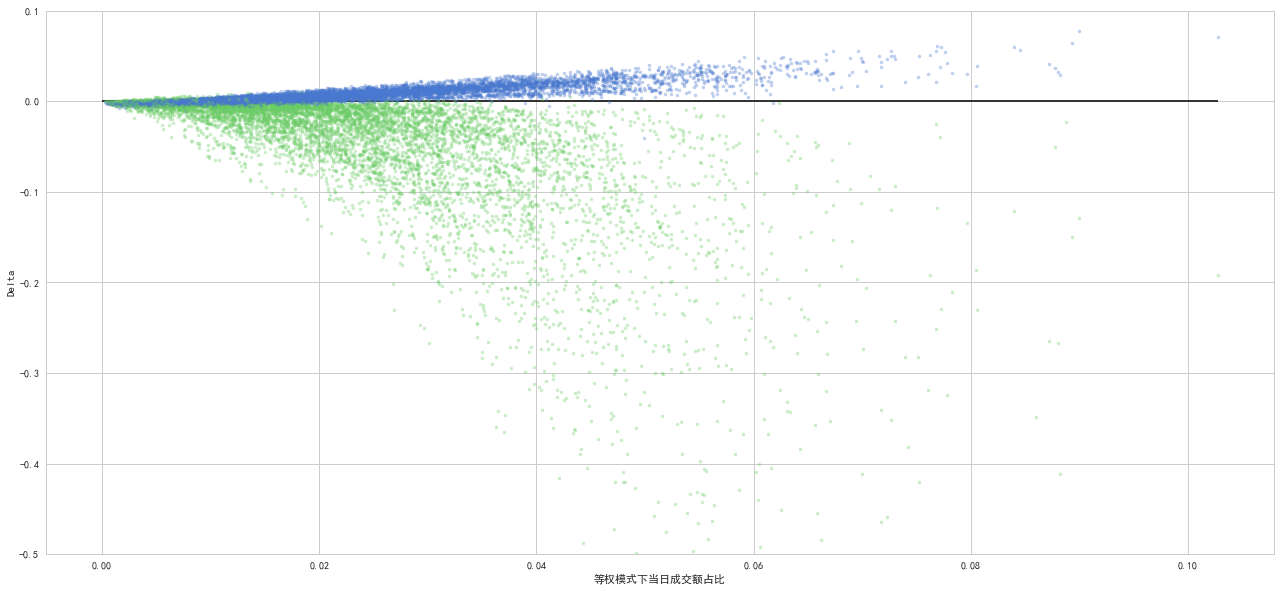

In [45]:
os.chdir(r'F:/金湖回测系统/6日循环/结果存放文件夹/')
for model in ['E1',]:
    if model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2']:
        universe = '2'; int_universe = 2
    elif model in ['E1', 'E2', 'F1']:
        universe = '6'; int_universe = 6
    elif model in ['G1']:
        universe = '3'; int_universe = 3
    f = open(universe + '_首组_' + model + '_' + model + '_5000万_7_50_支_股票池.csv')
    model_5000 = pd.read_csv(f, index_col=0)
    capital = 100000000
    buy_num = 50
    result_5000 = {}
    for date_index, date_value in enumerate(model_5000.index.tolist()):
        date_buy = model_5000.xs(date_value).dropna().tolist()
        weight_buy = pd.Series([1 / buy_num] * len(date_buy), index=date_buy)
        if date_index - int_universe + 1 >= 0:
            #date_sell = model_5000.xs(model_5000.index.tolist()[date_index - int_universe + 1]).dropna().tolist()
            #weight_sell = pd.Series([1 / buy_num] * len(date_sell), index=date_sell)
            #weighted_capital_5000 = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            weighted_capital_5000 = weight_buy * capital
            date_EL_score = (weighted_capital_5000/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_5000[date_value] = date_EL_score
            
    f = open(universe + '_首组_' + model + '_' + model + '_AMT0_5000万_7_50_支_权重.csv')
    model_liqadj_weight = pd.read_csv(f, index_col=0)
    model_liqadj_weight.columns = [int(i) for i in model_liqadj_weight.columns]
    result_liqadj = {}
    for date_index, date_value in enumerate(model_liqadj_weight.index.tolist()):
        weight_buy = model_liqadj_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            #weight_sell = model_liqadj_weight.xs(model_liqadj_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            #weighted_capital_liqadj = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            weighted_capital_liqadj = weight_buy * capital
            date_EL_score = (weighted_capital_liqadj/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_liqadj[date_value] = date_EL_score
            
    f = open(universe + '_首组_' + model + '_' + model + '_限定市值行业_4_15_7_50_支_权重.csv')
    model_mktind_weight = pd.read_csv(f, index_col=0)
    model_mktind_weight.columns = [int(i) for i in model_mktind_weight.columns]
    result_mktind = {}
    for date_index, date_value in enumerate(model_mktind_weight.index.tolist()):
        len_mktind = len(model_mktind_weight.xs(date_value).dropna())
        len_5000 = len(model_5000.xs(date_value).dropna())
        random_list = np.random.choice(range(0,len_mktind),len_5000,replace=False)
        weight_buy = model_mktind_weight.xs(date_value).dropna().iloc[random_list] *\
                               model_mktind_weight.xs(date_value).dropna().sum() /\
                               model_mktind_weight.xs(date_value).dropna().iloc[random_list].sum()
        if date_index - int_universe + 1 >= 0:
            #weight_sell = model_mktind_weight.xs(model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna().iloc[random_list] *\
            #                      model_mktind_weight.xs(model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna().sum() /\
            #                      model_mktind_weight.xs(model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna().iloc[random_list].sum()
            #weighted_capital_mktind = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            weighted_capital_mktind = weight_buy * capital
            date_EL_score = (weighted_capital_mktind/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_mktind[date_value] = date_EL_score

    result_5000 = pd.DataFrame.from_dict(result_5000).T
    result_liqadj = pd.DataFrame.from_dict(result_liqadj).T
    result_mktind = pd.DataFrame.from_dict(result_mktind).T
    plt.figure(figsize = (22,10))
    for i in result_5000.index:
        daily_info_5000 = result_5000.xs(i).dropna().sort_values().reset_index(drop=True)
        daily_info_liqadj = result_liqadj.xs(i).dropna().sort_values().reset_index(drop=True)
        daily_info_mktind = result_mktind.xs(i).dropna().sort_values().reset_index(drop=True)
        #plt.plot(daily_info_5000,'r',alpha = 0.05)
        #plt.plot(daily_info_liqadj,'b',alpha = 0.05)
        plt.plot(daily_info_5000.tolist(),(daily_info_5000 - daily_info_liqadj).tolist(),'b.',alpha = 0.35)
        #plt.plot(daily_info_5000.tolist(),(daily_info_mktind - daily_info_liqadj).tolist(),'g.',alpha = 0.35)
        plt.plot(daily_info_5000.tolist(),(daily_info_5000 - daily_info_mktind).tolist(),'g.',alpha = 0.35)
    plt.hlines(0,0,result_5000.max().max())
    plt.ylim(-0.5,0.1)
    plt.ylabel('Delta')
    plt.xlabel('等权模式下当日成交额占比')
    plt.show()

In [46]:
(result_5000.mean(axis = 1) - result_liqadj.mean(axis = 1)).mean()

0.0073290576004942185

In [35]:
(result_mktind.mean(axis = 1) - result_liqadj.mean(axis = 1)).mean()

0.051606118316144839

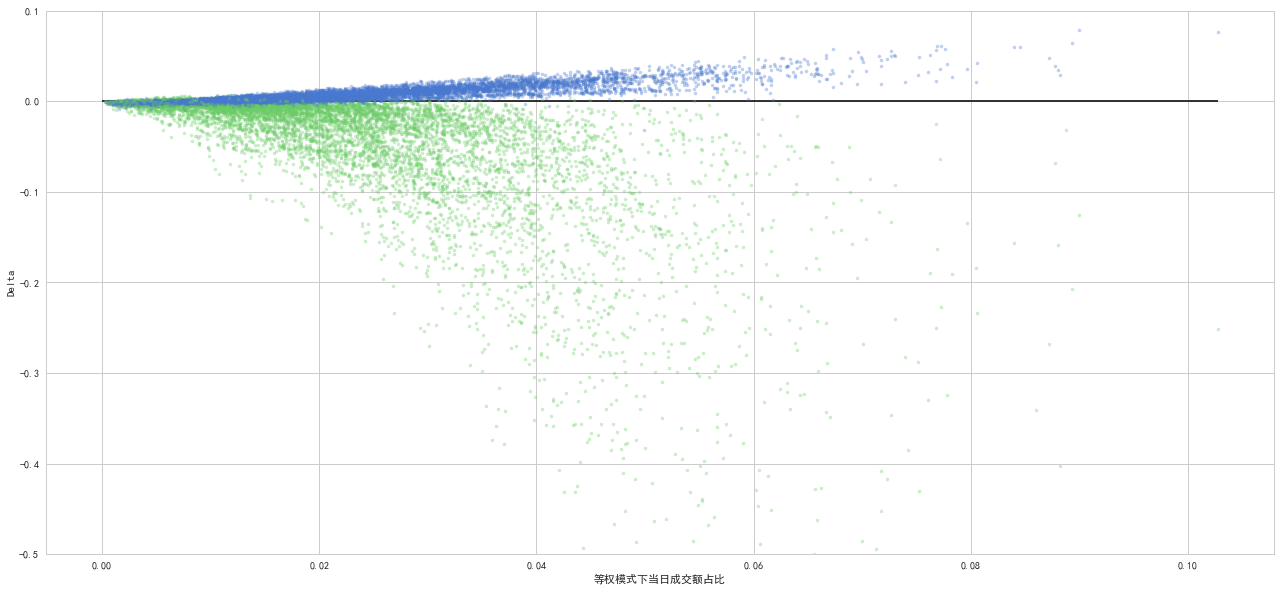

In [36]:
os.chdir(r'F:/金湖回测系统/6日循环/结果存放文件夹/')
for model in ['E1',]:
    if model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2']:
        universe = '2'; int_universe = 2
    elif model in ['E1', 'E2', 'F1']:
        universe = '6'; int_universe = 6
    elif model in ['G1']:
        universe = '3'; int_universe = 3
    f = open(universe + '_首组_' + model + '_' + model + '_5000万_7_50_支_股票池.csv')
    model_5000 = pd.read_csv(f, index_col=0)
    capital = 100000000
    buy_num = 50
    result_5000 = {}
    for date_index, date_value in enumerate(model_5000.index.tolist()):
        date_buy = model_5000.xs(date_value).dropna().tolist()
        weight_buy = pd.Series([1 / buy_num] * len(date_buy), index=date_buy)
        if date_index - int_universe + 1 >= 0:
            #date_sell = model_5000.xs(model_5000.index.tolist()[date_index - int_universe + 1]).dropna().tolist()
            #weight_sell = pd.Series([1 / buy_num] * len(date_sell), index=date_sell)
            #weighted_capital_5000 = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            weighted_capital_5000 = weight_buy * capital
            date_EL_score = (weighted_capital_5000/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_5000[date_value] = date_EL_score
            
    f = open(universe + '_首组_' + model + '_' + model + '_AMT5_5000万_7_50_支_权重.csv')
    model_liqadj_weight = pd.read_csv(f, index_col=0)
    model_liqadj_weight.columns = [int(i) for i in model_liqadj_weight.columns]
    result_liqadj = {}
    for date_index, date_value in enumerate(model_liqadj_weight.index.tolist()):
        weight_buy = model_liqadj_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            #weight_sell = model_liqadj_weight.xs(model_liqadj_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            #weighted_capital_liqadj = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            weighted_capital_liqadj = weight_buy * capital
            date_EL_score = (weighted_capital_liqadj/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_liqadj[date_value] = date_EL_score
            
    f = open(universe + '_首组_' + model + '_' + model + '_限定市值行业_4_15_7_50_支_权重.csv')
    model_mktind_weight = pd.read_csv(f, index_col=0)
    model_mktind_weight.columns = [int(i) for i in model_mktind_weight.columns]
    result_mktind = {}
    for date_index, date_value in enumerate(model_mktind_weight.index.tolist()):
        len_mktind = len(model_mktind_weight.xs(date_value).dropna())
        len_5000 = len(model_5000.xs(date_value).dropna())
        random_list = np.random.choice(range(0,len_mktind),len_5000,replace=False)
        weight_buy = model_mktind_weight.xs(date_value).dropna().iloc[random_list] *\
                               model_mktind_weight.xs(date_value).dropna().sum() /\
                               model_mktind_weight.xs(date_value).dropna().iloc[random_list].sum()
        if date_index - int_universe + 1 >= 0:
            #weight_sell = model_mktind_weight.xs(model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna().iloc[random_list] *\
            #                      model_mktind_weight.xs(model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna().sum() /\
            #                      model_mktind_weight.xs(model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna().iloc[random_list].sum()
            #weighted_capital_mktind = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            weighted_capital_mktind = weight_buy * capital
            date_EL_score = (weighted_capital_mktind/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_mktind[date_value] = date_EL_score

    result_5000 = pd.DataFrame.from_dict(result_5000).T
    result_liqadj = pd.DataFrame.from_dict(result_liqadj).T
    result_mktind = pd.DataFrame.from_dict(result_mktind).T
    plt.figure(figsize = (22,10))
    for i in result_5000.index:
        daily_info_5000 = result_5000.xs(i).dropna().sort_values().reset_index(drop=True)
        daily_info_liqadj = result_liqadj.xs(i).dropna().sort_values().reset_index(drop=True)
        daily_info_mktind = result_mktind.xs(i).dropna().sort_values().reset_index(drop=True)
        #plt.plot(daily_info_5000,'r',alpha = 0.05)
        #plt.plot(daily_info_liqadj,'b',alpha = 0.05)
        plt.plot(daily_info_5000.tolist(),(daily_info_5000 - daily_info_liqadj).tolist(),'b.',alpha = 0.35)
        #plt.plot(daily_info_5000.tolist(),(daily_info_mktind - daily_info_liqadj).tolist(),'g.',alpha = 0.35)
        plt.plot(daily_info_5000.tolist(),(daily_info_5000 - daily_info_mktind).tolist(),'g.',alpha = 0.35)
    plt.hlines(0,0,result_5000.max().max())
    plt.ylim(-0.5,0.1)
    plt.ylabel('Delta')
    plt.xlabel('等权模式下当日成交额占比')
    plt.show()

In [37]:
(result_5000.mean(axis = 1) - result_liqadj.mean(axis = 1)).mean()

0.0073069736463147903

In [38]:
(result_mktind.mean(axis = 1) - result_liqadj.mean(axis = 1)).mean()

0.051996293885081687

In [42]:
1000 * 1/6 * 1/50

3.333333333333333

In [ ]:
os.chdir(r'F:/金湖回测系统/6日循环/结果存放文件夹/')
for model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F1', 'G1']:
    if model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2']:
        universe = '2'
        int_universe = 2
    elif model in ['E1', 'E2', 'F1']:
        universe = '6'
        int_universe = 6
    elif model in ['G1']:
        universe = '3'
        int_universe = 3
    f = open(universe + '_首组_' + model + '_' + model + '_5000万_7_50_支_股票池.csv')
    model_5000 = pd.read_csv(f, index_col=0)
    capital = 10000000
    buy_num = 50
    result_5000 = {}
    for date_index, date_value in enumerate(model_5000.index.tolist()):
        date_buy = model_5000.xs(date_value).dropna().tolist()
        weight_buy = pd.Series([1 / buy_num] * len(date_buy), index=date_buy)
        if date_index - int_universe + 1 >= 0:
            date_sell = model_5000.xs(
                model_5000.index.tolist()[date_index - int_universe + 1]).dropna().tolist()
            weight_sell = pd.Series([1 / buy_num] * len(date_sell), index=date_sell)
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            #date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_5000[date_value] = date_EL_score.sum()
    result_5000 = pd.DataFrame.from_dict(result_5000, orient='index')[0]
    f = open(universe + '_首组_' + model + '_' + model +
             '_限定市值行业_4_15_7_50_支_权重.csv')
    model_mktind_weight = pd.read_csv(f, index_col=0)
    model_mktind_weight.columns = [int(i) for i in model_mktind_weight.columns]
    capital = 10000000
    result_mktind = {}
    for date_index, date_value in enumerate(
            model_mktind_weight.index.tolist()):
        weight_buy = model_mktind_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_mktind_weight.xs(
                model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            #date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_mktind[date_value] = date_EL_score.sum()
    result_mktind = pd.DataFrame.from_dict(result_mktind, orient='index')[0]
    f = open(universe + '_首组_' + model + '_' + model +
             '_VaR-AMT_5000万_7_50_支_权重.csv')
    model_amt_weight = pd.read_csv(f, index_col=0)
    model_amt_weight.columns = [int(i) for i in model_amt_weight.columns]
    capital = 10000000
    result_amt = {}
    for date_index, date_value in enumerate(model_amt_weight.index.tolist()):
        weight_buy = model_amt_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_amt_weight.xs(
                model_amt_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            #date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_amt[date_value] = date_EL_score.sum()
    result_amt = pd.DataFrame.from_dict(result_amt, orient='index')[0]
    f = open(universe + '_首组_' + model + '_' + model +
             '_VaR-AMTs_5000万_7_50_支_权重.csv')
    model_amts_weight = pd.read_csv(f, index_col=0)
    model_amts_weight.columns = [int(i) for i in model_amts_weight.columns]
    capital = 10000000
    result_amts = {}
    for date_index, date_value in enumerate(model_amts_weight.index.tolist()):
        weight_buy = model_amts_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_amts_weight.xs(
                model_amts_weight.index.tolist()[date_index - int_universe +1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            #date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amts.xs(date_value).replace(0,np.nan)).dropna()
            result_amts[date_value] = date_EL_score.sum()
    result_amts = pd.DataFrame.from_dict(result_amts, orient='index')[0]
    f = open(universe + '_首组_' + model + '_' + model +
             '_VaR-AMTsc_5000万_7_50_支_权重.csv')
    model_amtsc_weight = pd.read_csv(f, index_col=0)
    model_amtsc_weight.columns = [int(i) for i in model_amtsc_weight.columns]
    capital = 10000000
    result_amtsc = {}
    for date_index, date_value in enumerate(model_amtsc_weight.index.tolist()):
        weight_buy = model_amtsc_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_amtsc_weight.xs(
                model_amtsc_weight.index.tolist()[date_index - int_universe +1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            #date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amtsc.xs(date_value).replace(0,np.nan)).dropna()
            result_amtsc[date_value] = date_EL_score.sum()
    result_amtsc = pd.DataFrame.from_dict(result_amtsc, orient='index')[0]
    f = open(universe + '_首组_' + model + '_' + model +
             '_VaR-AMTsc2_5000万_7_50_支_权重.csv')
    model_amtsc2_weight = pd.read_csv(f, index_col=0)
    model_amtsc2_weight.columns = [int(i) for i in model_amtsc2_weight.columns]
    capital = 10000000
    result_amtsc2 = {}
    for date_index, date_value in enumerate(model_amtsc2_weight.index.tolist()):
        weight_buy = model_amtsc2_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_amtsc2_weight.xs(
                model_amtsc2_weight.index.tolist()[date_index - int_universe +1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            #date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amtsc2.xs(date_value).replace(0,np.nan)).dropna()
            result_amtsc2[date_value] = date_EL_score.sum()
    result_amtsc2 = pd.DataFrame.from_dict(result_amtsc2, orient='index')[0]
    print(model)
    print('normal', result_5000.mean())
    print('mktind', result_mktind.mean())
    print('amt ', result_amt.mean())
    print('amts ', result_amts.mean())
    print('amtsc ', result_amtsc.mean())
    print('amtsc2 ', result_amtsc2.mean())
    plt.figure(figsize=(16, 3))
    plt.plot(result_5000.tolist(), label='Normal')
    plt.plot(result_mktind.tolist(), label='Mkt-Ind')
    plt.plot(result_amt.tolist(), label='amt')
    plt.plot(result_amts.tolist(), label='amts')
    plt.plot(result_amtsc.tolist(), label='amtsc')
    plt.plot(result_amtsc2.tolist(), label='amtsc2')
    plt.title(model)
    plt.legend()
    plt.show()

B3
normal 0.00210921478833
mktind 0.00231611363336
var-amt 2 0.000940599972926


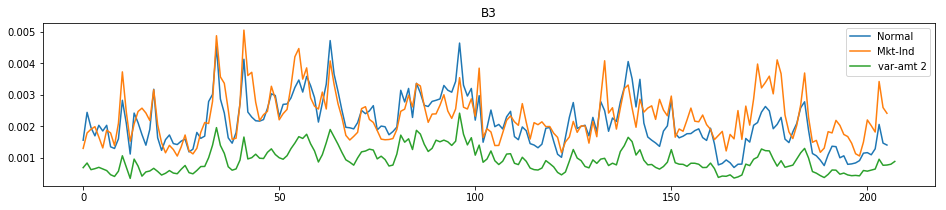

C3
normal 0.00198823627243
mktind 0.00222772603327
var-amt 2 0.000896184275398


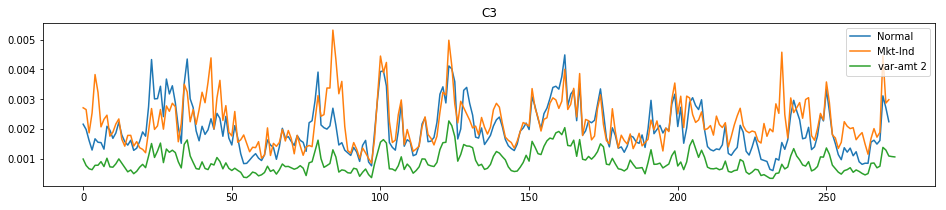

E1
normal 0.00229552131163
mktind 0.00260173578959
var-amt 2 0.00111229000155


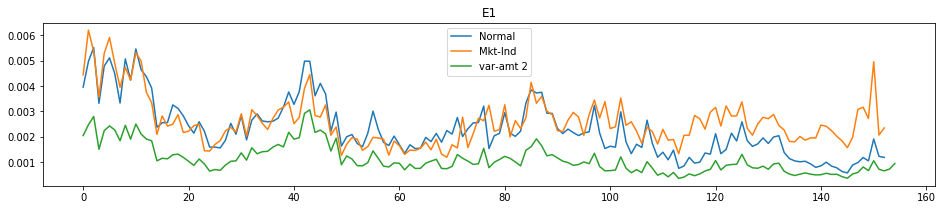

E2
normal 0.00236660593998
mktind 0.00256620312956
var-amt 2 0.00113376386448


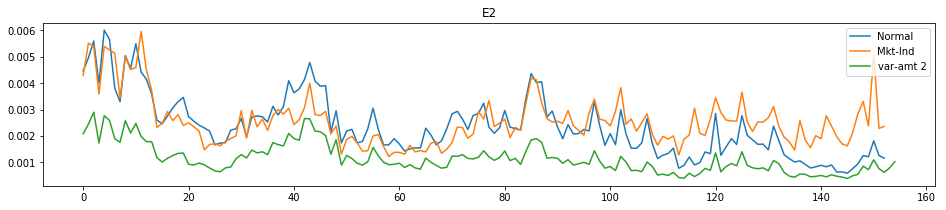

F1
normal 0.00192758177326
mktind 0.00231695408974
var-amt 2 0.000923668384951


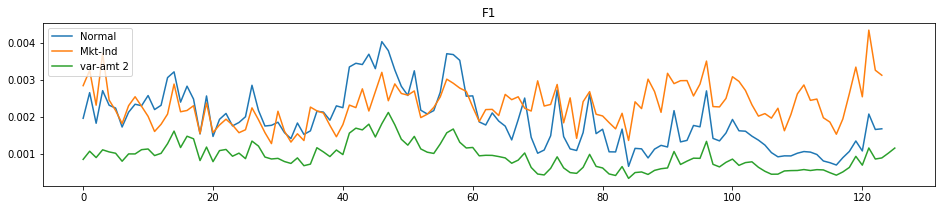

G1
normal 0.00222079262259
mktind 0.0025456047428
var-amt 2 0.00101158301069


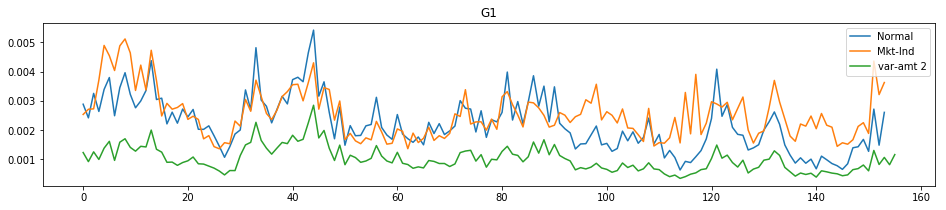

In [121]:
os.chdir(r'F:/金湖回测系统/6日循环/结果存放文件夹/')
#for model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F1', 'G1']:
for model in ['B3','C3','E1','E2','F1','G1']:
    if model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2']:
        universe = '2'
        int_universe = 2
    elif model in ['E1', 'E2', 'F1']:
        universe = '6'
        int_universe = 6
    elif model in ['G1']:
        universe = '3'
        int_universe = 3

    f = open(universe + '_首组_' + model + '_' + model + '_5000万_7_50_支_股票池.csv')
    model_5000 = pd.read_csv(f, index_col=0)
    capital = 10000000
    buy_num = 50
    result_5000 = {}
    for date_index, date_value in enumerate(model_5000.index.tolist()):
        date_buy = model_5000.xs(date_value).dropna().tolist()
        weight_buy = pd.Series([1 / buy_num] * len(date_buy), index=date_buy)
        if date_index - int_universe + 1 >= 0:
            date_sell = model_5000.xs(
                model_5000.index.tolist()[date_index - int_universe + 1]).dropna().tolist()
            weight_sell = pd.Series([1 / buy_num] * len(date_sell), index=date_sell)
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            #date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_5000[date_value] = date_EL_score.mean()
    result_5000 = pd.DataFrame.from_dict(result_5000, orient='index')[0]

    f = open(universe + '_首组_' + model + '_' + model +
             '_限定市值行业_4_15_7_50_支_权重.csv')
    model_mktind_weight = pd.read_csv(f, index_col=0)
    model_mktind_weight.columns = [int(i) for i in model_mktind_weight.columns]
    capital = 10000000
    result_mktind = {}
    for date_index, date_value in enumerate(
            model_mktind_weight.index.tolist()):
        weight_buy = model_mktind_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_mktind_weight.xs(
                model_mktind_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).sum()
            date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            #date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_mktind[date_value] = date_EL_score.mean()
    result_mktind = pd.DataFrame.from_dict(result_mktind, orient='index')[0]
    
    f = open(universe + '_首组_' + model + '_' + model +
             '_VaR-AMTsc3_5000万_7_50_支_权重.csv')
    model_amt_2_weight = pd.read_csv(f, index_col=0)
    model_amt_2_weight.columns = [int(i) for i in model_amt_2_weight.columns]
    capital = 10000000
    result_amt_2 = {}
    for date_index, date_value in enumerate(model_amt_2_weight.index.tolist()):
        weight_buy = model_amt_2_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_amt_2_weight.xs(
                model_amt_2_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            weighted_capital = ((weight_buy * capital).append(
                weight_sell * capital)).groupby(level=0).mean()
            date_EL_score = EL_score(weighted_capital,date_value,delta=1).replace(np.inf,np.nan)
            #date_EL_score = Adjusted_Amihud_score(weighted_capital, date_value, delta=1).replace(np.inf, np.nan)
            #date_EL_score = (weighted_capital/amt.xs(date_value).replace(0,np.nan)).dropna()
            result_amt_2[date_value] = date_EL_score.mean()
    result_amt_2 = pd.DataFrame.from_dict(result_amt_2, orient='index')[0]
    
    print(model)
    print('normal', result_5000.mean())
    print('mktind', result_mktind.mean())
    print('var-amt 2', result_amt_2.mean())
    plt.figure(figsize=(16, 3))
    plt.plot(result_5000.tolist(), label='Normal')
    plt.plot(result_mktind.tolist(), label='Mkt-Ind')
    plt.plot(result_amt_2.tolist(), label='var-amt 2')
    plt.title(model)
    plt.legend()
    plt.show()

In [119]:
date_EL_score.mean()

0.0023172105659723294

In [14]:
os.chdir(r'C:/Users/bj/Desktop/刘泽丹/Code/')

In [15]:
import pickle
with open('permanent_volume_mean10.pickle', 'rb') as handle:
    permanent_fitting_result = pickle.load(handle)
for key in permanent_fitting_result.keys():
    permanent_fitting_result[key] = pd.DataFrame(permanent_fitting_result[key]).T
    permanent_fitting_result[key].columns = ['optimality','gamma','alpha','delta','constant','R2','non-centered R2']

In [16]:
with open('temporary_volume_mean10.pickle', 'rb') as handle:
    temporary_fitting_result = pickle.load(handle)
for key in temporary_fitting_result.keys():
    temporary_fitting_result[key] = pd.DataFrame(temporary_fitting_result[key]).T
    temporary_fitting_result[key].columns = ['optimality','eta','beta','constant','R2','non-centered R2']

In [17]:
real_impact_cost = (adjvwap - adjopen)/adjopen
real_permanent_part = (adjclose - adjopen)/adjopen
real_temporary_part = real_impact_cost - 1/2 * real_permanent_part

In [146]:
n_percentile = 10
testing_date = 20180102
todate_mkt_cap_ard = mkt_cap_ard.xs(testing_date).sort_values().dropna()
full_permanent_series = {}
full_temporary_series = {}
full_impact_cost_series = {}
for percentile in range(n_percentile):
    sub_stock_list = todate_mkt_cap_ard[int(len(todate_mkt_cap_ard)/n_percentile*percentile):int(len(todate_mkt_cap_ard)/n_percentile*(percentile+1))].index.tolist()
    num = 0
    while(True):    
        if mf_volume.xs(testing_date).xs(sub_stock_list[num]) != 0 and pd.notnull(mf_volume.xs(testing_date).xs(sub_stock_list[num])) \
            and pd.notnull(volume_rolling.xs(testing_date).xs(sub_stock_list[num])):
            sub_stock_list = sub_stock_list[num]
            print(sub_stock_list)
            break
        else:
            num += 1
    permanent_series = []
    temporary_series = []
    impact_cost_series = []
    for added_volume in np.linspace(-10000000,10000000,1001):
        ###change sub_X to wanted VOLUME###
        sub_X = mf_volume.loc[testing_date,sub_stock_list]
        new_sub_X = mf_volume.loc[testing_date,sub_stock_list] + added_volume
        sub_V = volume_rolling.loc[testing_date,sub_stock_list]
        sub_theta = free_float_shares.loc[testing_date,sub_stock_list]
        sub_sigma = ohlc_sigma_c.loc[testing_date,sub_stock_list]

        gamma = permanent_fitting_result[percentile].xs(testing_date)['gamma']
        alpha = permanent_fitting_result[percentile].xs(testing_date)['alpha']
        delta = permanent_fitting_result[percentile].xs(testing_date)['delta']
        constant_permanent = permanent_fitting_result[percentile].xs(testing_date)['constant']
        eta = temporary_fitting_result[percentile].xs(testing_date)['eta']
        beta = temporary_fitting_result[percentile].xs(testing_date)['beta']
        constant_temporary = temporary_fitting_result[percentile].xs(testing_date)['constant']

        permanent_part = gamma * np.sign(sub_X) * (np.abs(sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
            constant_permanent * sub_sigma
        temporary_part = eta * np.sign(sub_X) * (np.abs(sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma
        impact_cost = 1/2 * permanent_part + temporary_part
        
        new_permanent_part = gamma * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
            constant_permanent * sub_sigma
        new_temporary_part = eta * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma
        new_impact_cost = 1/2 * new_permanent_part + new_temporary_part
        
        delta_permanent_part = gamma * np.sign(added_volume) * (np.abs(added_volume/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
            constant_permanent * sub_sigma
        delta_temporary_part = eta * np.sign(added_volume) * (np.abs(added_volume/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma
        delta_impact_cost = 1/2 * delta_permanent_part + delta_temporary_part
        
#         permanent_series.append(new_permanent_part - permanent_part)
#         temporary_series.append(new_temporary_part - temporary_part)
#         impact_cost_series.append(new_impact_cost - impact_cost)
        
        permanent_series.append(delta_permanent_part/sub_sigma)
        temporary_series.append(delta_temporary_part/sub_sigma)
        impact_cost_series.append(delta_impact_cost/sub_sigma)
    full_permanent_series[percentile] = pd.Series(permanent_series,index = np.linspace(-1000000,1000000,1001))
    full_temporary_series[percentile] = pd.Series(temporary_series,index = np.linspace(-1000000,1000000,1001))
    full_impact_cost_series[percentile] = pd.Series(impact_cost_series,index = np.linspace(-1000000,1000000,1001))

300029
300478
603208
600712
2090
2551
2488
300253
601128
2640


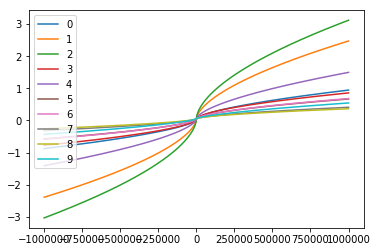

In [147]:
for key in full_permanent_series.keys():
    plt.plot(full_permanent_series[key],label=key)
plt.legend()
plt.show()

0.0139968690993
0.0165983773518


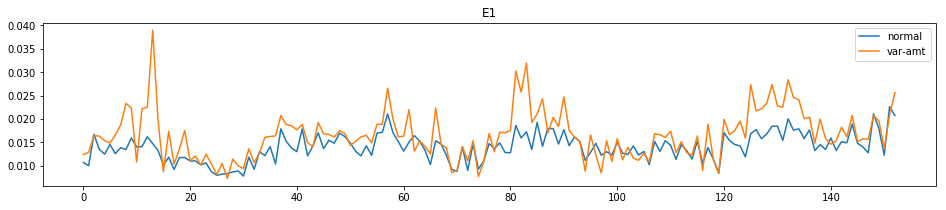

In [24]:
os.chdir(r'F:/金湖回测系统/6日循环/结果存放文件夹/')
n_percentile = 10
#for model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F1', 'G1']:
for model in ['E1']:
    if model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2']:
        universe = '2'; int_universe = 2
    elif model in ['E1', 'E2', 'F1']:
        universe = '6'; int_universe = 6
    elif model in ['G1']:
        universe = '3'; int_universe = 3

    capital = 1000000000/int_universe
    
    f = open(universe + '_首组_' + model + '_' + model + '_5000万_7_50_支_股票池.csv')
    model_5000 = pd.read_csv(f, index_col=0)
    buy_num = 50
    weighted_impact_cost_record = {}
    for date_index, date_value in enumerate(model_5000.index.tolist()):
        date_buy = model_5000.xs(date_value).dropna().tolist()
        weight_buy = pd.Series([1 / buy_num] * len(date_buy), index=date_buy)
        if date_index - int_universe + 1 >= 0:
            date_sell = model_5000.xs(
                model_5000.index.tolist()[date_index - int_universe + 1]).dropna().tolist()
            weight_sell = pd.Series([1 / buy_num] * len(date_sell), index=date_sell)
            weighted_capital = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()
            todate_mkt_cap_ard = volume_rolling.xs(date_value).sort_values().dropna()
            impact_cost_record = pd.Series()
            for percentile in range(n_percentile):
                stock_list = todate_mkt_cap_ard[int(len(todate_mkt_cap_ard)/n_percentile*percentile):int(len(todate_mkt_cap_ard)/n_percentile*(percentile+1))].index.tolist()
                sub_stock_list = [st for st in weighted_capital.index if st in stock_list]
                
                sub_weighted_capital = weighted_capital.loc[sub_stock_list]
                added_volume = sub_weighted_capital/vwap.xs(date_value).loc[sub_weighted_capital.index]
                sub_X = np.abs(mf_volume.loc[date_value,sub_weighted_capital.index])
                new_sub_X = sub_X + added_volume
                sub_V = volume_rolling.loc[date_value,sub_weighted_capital.index]
                sub_theta = free_float_shares.loc[date_value,sub_weighted_capital.index]
                sub_sigma = ohlc_sigma_c.loc[date_value,sub_weighted_capital.index]

                gamma = permanent_fitting_result[percentile].xs(date_value)['gamma']
                alpha = permanent_fitting_result[percentile].xs(date_value)['alpha']
                delta = permanent_fitting_result[percentile].xs(date_value)['delta']
                constant_permanent = permanent_fitting_result[percentile].xs(date_value)['constant']
                eta = temporary_fitting_result[percentile].xs(date_value)['eta']
                beta = temporary_fitting_result[percentile].xs(date_value)['beta']
                constant_temporary = temporary_fitting_result[percentile].xs(date_value)['constant']
                
                new_permanent_part = np.abs(gamma * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
                    constant_permanent * sub_sigma)
                new_temporary_part = np.abs(eta * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma)
                new_impact_cost = 1/2 * new_permanent_part + new_temporary_part
                
                permanent_part = np.abs(gamma * np.sign(sub_X) * (np.abs(sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
                    constant_permanent * sub_sigma)
                temporary_part = np.abs(eta * np.sign(sub_X) * (np.abs(sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma)
                impact_cost = 1/2 * permanent_part + temporary_part
                
                impact_cost_record = impact_cost_record.append((new_impact_cost - impact_cost)/sub_sigma)
            weighted_impact_cost = (impact_cost_record * weighted_capital).sum()/(capital*2)
            weighted_impact_cost_record[date_value] = weighted_impact_cost
    
    f = open(universe + '_首组_' + model + '_' + model + '_VaR-AMTsc2_5000万_7_50_支_权重.csv')
    model_amt_2_weight = pd.read_csv(f, index_col=0)
    model_amt_2_weight.columns = [int(i) for i in model_amt_2_weight.columns]
    weighted_impact_cost_record_varamt2 = {}
    for date_index, date_value in enumerate(model_amt_2_weight.index.tolist()):
        weight_buy = model_amt_2_weight.xs(date_value).dropna()
        if date_index - int_universe + 1 >= 0:
            weight_sell = model_amt_2_weight.xs(model_amt_2_weight.index.tolist()[date_index - int_universe + 1]).dropna()
            varamt2_weighted_capital = ((weight_buy * capital).append(weight_sell * capital)).groupby(level=0).sum()

            todate_mkt_cap_ard = volume_rolling.xs(date_value).sort_values().dropna()
            impact_cost_record_varamt2 = pd.Series()
            for percentile in range(n_percentile):
                stock_list = todate_mkt_cap_ard[int(len(todate_mkt_cap_ard)/n_percentile*percentile):int(len(todate_mkt_cap_ard)/n_percentile*(percentile+1))].index.tolist()
                sub_stock_list = [st for st in varamt2_weighted_capital.index if st in stock_list]

                sub_weighted_capital = varamt2_weighted_capital.loc[sub_stock_list]
                added_volume = sub_weighted_capital/vwap.xs(date_value).loc[sub_weighted_capital.index]
                sub_X = np.abs(mf_volume.loc[date_value,sub_weighted_capital.index])
                new_sub_X = sub_X + added_volume
                sub_V = volume_rolling.loc[date_value,sub_weighted_capital.index]
                sub_theta = free_float_shares.loc[date_value,sub_weighted_capital.index]
                sub_sigma = ohlc_sigma_c.loc[date_value,sub_weighted_capital.index]

                gamma = permanent_fitting_result[percentile].xs(date_value)['gamma']
                alpha = permanent_fitting_result[percentile].xs(date_value)['alpha']
                delta = permanent_fitting_result[percentile].xs(date_value)['delta']
                constant_permanent = permanent_fitting_result[percentile].xs(date_value)['constant']
                eta = temporary_fitting_result[percentile].xs(date_value)['eta']
                beta = temporary_fitting_result[percentile].xs(date_value)['beta']
                constant_temporary = temporary_fitting_result[percentile].xs(date_value)['constant']

                new_permanent_part = np.abs(gamma * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
                    constant_permanent * sub_sigma)
                new_temporary_part = np.abs(eta * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma)
                new_impact_cost = 1/2 * new_permanent_part + new_temporary_part
                
                permanent_part = np.abs(gamma * np.sign(sub_X) * (np.abs(sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
                    constant_permanent * sub_sigma)
                temporary_part = np.abs(eta * np.sign(sub_X) * (np.abs(sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma)
                impact_cost = 1/2 * permanent_part + temporary_part
                
                impact_cost_record_varamt2 = impact_cost_record_varamt2.append((new_impact_cost - impact_cost)/sub_sigma)
            weighted_impact_cost_varamt2 = (impact_cost_record_varamt2 * varamt2_weighted_capital).sum()/(capital*2)
            weighted_impact_cost_record_varamt2[date_value] = weighted_impact_cost_varamt2
    
    plt.figure(figsize = (16,3))
    plt.plot(pd.DataFrame.from_dict(weighted_impact_cost_record,orient='index')[0].tolist(),label='normal')
    plt.plot(pd.DataFrame.from_dict(weighted_impact_cost_record_varamt2,orient='index')[0].tolist(),label='var-amt')
    print(pd.DataFrame.from_dict(weighted_impact_cost_record,orient='index')[0].mean())
    print(pd.DataFrame.from_dict(weighted_impact_cost_record_varamt2,orient='index')[0].mean())
    plt.title(model)
    plt.legend()
    plt.show()

0.00896203062153
0.00941047969387


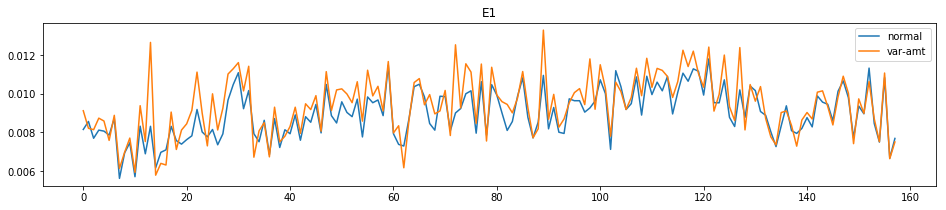

0.00893741257845
0.00941953933691


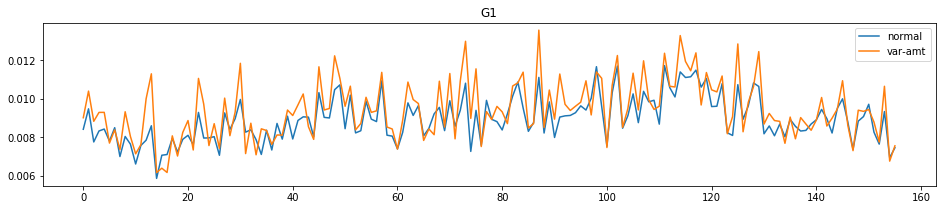

0.00933739470189
0.00978821415824


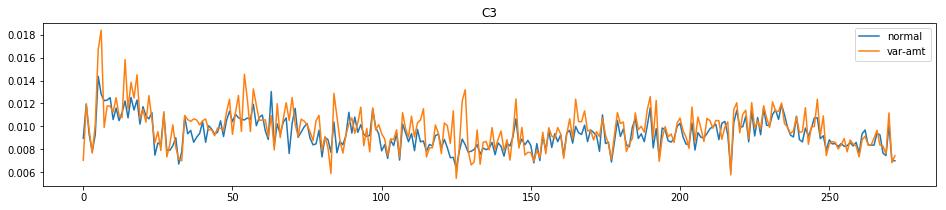

In [125]:
os.chdir(r'F:/金湖回测系统/6日循环/结果存放文件夹/')
n_percentile = 10
#for model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2', 'E1', 'E2', 'F1', 'G1']:
for model in ['E1','G1','C3']:
    if model in ['A2', 'A3', 'B1', 'B3', 'B4', 'C2', 'C3', 'D1', 'D2']:
        universe = '2'; int_universe = 2
    elif model in ['E1', 'E2', 'F1']:
        universe = '6'; int_universe = 6
    elif model in ['G1']:
        universe = '3'; int_universe = 3

    capital = 50000000/int_universe
    
    f = open(universe + '_首组_' + model + '_' + model + '_5000万_7_50_支_股票池.csv')
    model_5000 = pd.read_csv(f, index_col=0)
    buy_num = 50
    weighted_impact_cost_record = {}
    for date_index, date_value in enumerate(model_5000.index.tolist()):
        date_buy = model_5000.xs(date_value).dropna().tolist()
        weight_buy = pd.Series([1 / buy_num] * len(date_buy), index=date_buy)
        weighted_capital = weight_buy * capital
        todate_mkt_cap_ard = volume_rolling.xs(date_value).sort_values().dropna()
        impact_cost_record = pd.Series()
        for percentile in range(n_percentile):
            stock_list = todate_mkt_cap_ard[int(len(todate_mkt_cap_ard)/n_percentile*percentile):int(len(todate_mkt_cap_ard)/n_percentile*(percentile+1))].index.tolist()
            sub_stock_list = [st for st in weighted_capital.index if st in stock_list]
            
            sub_weighted_capital = weighted_capital.loc[sub_stock_list]
            added_volume = sub_weighted_capital/vwap.xs(date_value).loc[sub_weighted_capital.index]
            sub_X = mf_volume.loc[date_value,sub_weighted_capital.index]
            new_sub_X = sub_X + added_volume
            sub_V = volume_rolling.loc[date_value,sub_weighted_capital.index]
            sub_theta = free_float_shares_rolling.loc[date_value,sub_weighted_capital.index]

            gamma = permanent_fitting_result[percentile].xs(date_value)['gamma']
            alpha = permanent_fitting_result[percentile].xs(date_value)['alpha']
            delta = permanent_fitting_result[percentile].xs(date_value)['delta']
            constant_permanent = permanent_fitting_result[percentile].xs(date_value)['constant']
            eta = temporary_fitting_result[percentile].xs(date_value)['eta']
            beta = temporary_fitting_result[percentile].xs(date_value)['beta']
            constant_temporary = temporary_fitting_result[percentile].xs(date_value)['constant']

            new_permanent_part = np.abs(gamma * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta))
            new_temporary_part = np.abs(eta * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**beta))
            new_impact_cost = 1/2 * new_permanent_part + new_temporary_part

            permanent_part = np.abs(gamma * np.sign(sub_X) * (np.abs(sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta))
            temporary_part = np.abs(eta * np.sign(sub_X) * (np.abs(sub_X/sub_V)**beta))
            impact_cost = 1/2 * permanent_part + temporary_part

            impact_cost_record = impact_cost_record.append((new_temporary_part))
        weighted_impact_cost = (impact_cost_record * weighted_capital).sum()/(capital*2)
        weighted_impact_cost_record[date_value] = weighted_impact_cost
    
    f = open(universe + '_首组_' + model + '_' + model + '_VaR-AMTsc2_5000万_7_50_支_权重.csv')
    model_amt_2_weight = pd.read_csv(f, index_col=0)
    model_amt_2_weight.columns = [int(i) for i in model_amt_2_weight.columns]
    weighted_impact_cost_record_varamt2 = {}
    for date_index, date_value in enumerate(model_amt_2_weight.index.tolist()):
        weight_buy = model_amt_2_weight.xs(date_value).dropna()
        varamt2_weighted_capital = weight_buy * capital

        todate_mkt_cap_ard = volume_rolling.xs(date_value).sort_values().dropna()
        impact_cost_record_varamt2 = pd.Series()
        for percentile in range(n_percentile):
            stock_list = todate_mkt_cap_ard[int(len(todate_mkt_cap_ard)/n_percentile*percentile):int(len(todate_mkt_cap_ard)/n_percentile*(percentile+1))].index.tolist()
            sub_stock_list = [st for st in varamt2_weighted_capital.index if st in stock_list]

            sub_weighted_capital = varamt2_weighted_capital.loc[sub_stock_list]
            added_volume = sub_weighted_capital/vwap.xs(date_value).loc[sub_weighted_capital.index]
            sub_X = mf_volume.loc[date_value,sub_weighted_capital.index]
            new_sub_X = sub_X + added_volume
            sub_V = volume_rolling.loc[date_value,sub_weighted_capital.index]
            sub_theta = free_float_shares_rolling.loc[date_value,sub_weighted_capital.index]

            gamma = permanent_fitting_result[percentile].xs(date_value)['gamma']
            alpha = permanent_fitting_result[percentile].xs(date_value)['alpha']
            delta = permanent_fitting_result[percentile].xs(date_value)['delta']
            constant_permanent = permanent_fitting_result[percentile].xs(date_value)['constant']
            eta = temporary_fitting_result[percentile].xs(date_value)['eta']
            beta = temporary_fitting_result[percentile].xs(date_value)['beta']
            constant_temporary = temporary_fitting_result[percentile].xs(date_value)['constant']

            new_permanent_part = np.abs(gamma * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta))
            new_temporary_part = np.abs(eta * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**beta))
            new_impact_cost = 1/2 * new_permanent_part + new_temporary_part

            permanent_part = np.abs(gamma * np.sign(sub_X) * (np.abs(sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta))
            temporary_part = np.abs(eta * np.sign(sub_X) * (np.abs(sub_X/sub_V)**beta))
            impact_cost = 1/2 * permanent_part + temporary_part

            impact_cost_record_varamt2 = impact_cost_record_varamt2.append((new_temporary_part))
        weighted_impact_cost_varamt2 = (impact_cost_record_varamt2 * varamt2_weighted_capital).sum()/(capital*2)
        weighted_impact_cost_record_varamt2[date_value] = weighted_impact_cost_varamt2
    
    plt.figure(figsize = (16,3))
    plt.plot(pd.DataFrame.from_dict(weighted_impact_cost_record,orient='index')[0].tolist(),label='normal')
    plt.plot(pd.DataFrame.from_dict(weighted_impact_cost_record_varamt2,orient='index')[0].tolist(),label='var-amt')
    print(pd.DataFrame.from_dict(weighted_impact_cost_record,orient='index')[0].mean())
    print(pd.DataFrame.from_dict(weighted_impact_cost_record_varamt2,orient='index')[0].mean())
    plt.title(model)
    plt.legend()
    plt.show()

In [95]:
n_percentile = 10
testing_date = 20181127
the_stock = 600568
todate_mkt_cap_ard = mkt_cap_ard.xs(testing_date).sort_values().dropna()
full_permanent_series = {}
full_temporary_series = {}
full_impact_cost_series = {}
for percentile in range(n_percentile):
    sub_stock_list = todate_mkt_cap_ard[int(len(todate_mkt_cap_ard)/n_percentile*percentile):int(len(todate_mkt_cap_ard)/n_percentile*(percentile+1))].index.tolist()
    if the_stock not in sub_stock_list:
        continue
#     num = 0
#     while(True):    
#         if mf_volume.xs(testing_date).xs(the_stock[num]) != 0 and pd.notnull(mf_volume.xs(testing_date).xs(the_stock[num])) \
#             and pd.notnull(volume_rolling.xs(testing_date).xs(the_stock[num])):
#             the_stock = the_stock[num]
#             print(the_stock)
#             break
#         else:
#             num += 1
#    the_stock = selected[percentile]
    permanent_series = []
    temporary_series = []
    impact_cost_series = []
    for added_volume in np.linspace(-10000000,10000000,1001):
        ###change sub_X to wanted VOLUME###
        sub_X = mf_volume.loc[testing_date,the_stock]
        new_sub_X = mf_volume.loc[testing_date,the_stock] + added_volume
        sub_V = volume_rolling.loc[testing_date,the_stock]
        sub_theta = free_float_shares.loc[testing_date,the_stock]
        sub_sigma = ohlc_sigma_c.loc[testing_date,the_stock]

        gamma = permanent_fitting_result[percentile].xs(testing_date)['gamma']
        alpha = permanent_fitting_result[percentile].xs(testing_date)['alpha']
        delta = permanent_fitting_result[percentile].xs(testing_date)['delta']
        constant_permanent = permanent_fitting_result[percentile].xs(testing_date)['constant']
        eta = temporary_fitting_result[percentile].xs(testing_date)['eta']
        beta = temporary_fitting_result[percentile].xs(testing_date)['beta']
        constant_temporary = temporary_fitting_result[percentile].xs(testing_date)['constant']

        permanent_part = gamma * np.sign(sub_X) * (np.abs(sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
            constant_permanent * sub_sigma
        temporary_part = eta * np.sign(sub_X) * (np.abs(sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma
        impact_cost = 1/2 * permanent_part + temporary_part
        
        new_permanent_part = gamma * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
            constant_permanent * sub_sigma
        new_temporary_part = eta * np.sign(new_sub_X) * (np.abs(new_sub_X/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma
        new_impact_cost = 1/2 * new_permanent_part + new_temporary_part
        
        delta_permanent_part = gamma * np.sign(added_volume) * (np.abs(added_volume/sub_V)**alpha) * ((sub_theta/sub_V)**delta) * sub_sigma +\
            constant_permanent * sub_sigma
        delta_temporary_part = eta * np.sign(added_volume) * (np.abs(added_volume/sub_V)**beta) * sub_sigma + constant_temporary * sub_sigma
        delta_impact_cost = 1/2 * delta_permanent_part + delta_temporary_part
        
#         permanent_series.append(new_permanent_part - permanent_part)
#         temporary_series.append(new_temporary_part - temporary_part)
#         impact_cost_series.append(new_impact_cost - impact_cost)
        
        permanent_series.append(delta_permanent_part/sub_sigma)
        temporary_series.append(delta_temporary_part/sub_sigma)
        impact_cost_series.append(delta_impact_cost/sub_sigma)

    full_permanent_series[percentile] = pd.Series(permanent_series,index = np.linspace(-1000000,1000000,1001))
    full_temporary_series[percentile] = pd.Series(temporary_series,index = np.linspace(-1000000,1000000,1001))
    full_impact_cost_series[percentile] = pd.Series(impact_cost_series,index = np.linspace(-1000000,1000000,1001))

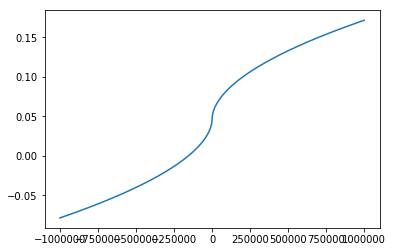

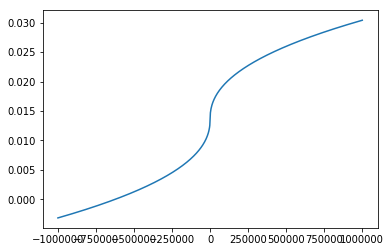

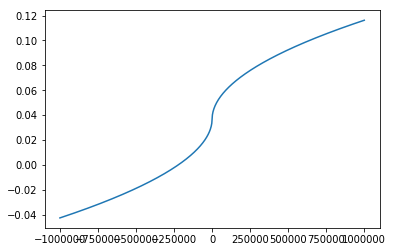

In [96]:
for key in full_permanent_series.keys():
    plt.plot(full_permanent_series[key])
    plt.show()
for key in full_temporary_series.keys():
    plt.plot(full_temporary_series[key])
    plt.show()
for key in full_impact_cost_series.keys():
    plt.plot(full_impact_cost_series[key])
    plt.show()

Text(0.5,1,'1.5')

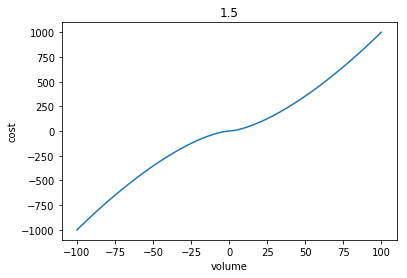

In [154]:
x=np.linspace(-100,100,101)
y=np.sign(x) * np.abs(x) ** 1.5
plt.plot(x,y)
plt.xlabel('volume')
plt.ylabel('cost')
plt.title('1.5')